In [1]:
import os
import sys
import numpy as np
import pandas as pd
from itertools import product
from datetime import datetime
from talib import RSI
from multiprocessing import Pool, cpu_count
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pyfolio as pf
import warnings
from time import time, sleep

warnings.filterwarnings('ignore')

# To display multiple outputs from the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 100)
pd.set_option('max_colwidth', 400)
pd.set_option('expand_frame_repr', False)


%matplotlib inline
!python -V

/home/solidsnake/epat/assignments/venv/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


Python 3.8.10


### Q1: Backtest a strategy using three moving averages on any indices such as Nifty50, SPY, HSI and so on. ###
1. Compute three moving averages of 20, 40, and 80.
2. Go long when the price crosses above all three moving averages.
3. Exit the long position when the price crosses below any of the three moving averages.
4. Go short when the price crosses below all three moving averages.
5. Exit the short position when the price crosses above any of the three moving averages.
6. Optional: Optimise all three moving averages

In [2]:
asset= "SPY"
start_date = datetime(2010, 1, 1)
end_date = datetime(2022, 6, 30)
def download_data(ticker, start = start_date, end = end_date):
    """ 
    The function downloads daily market data to a pandas DataFrame 
    using the 'yfinance' API between the dates specified. If dates are not specified
    they default from 2015 up until now. Then, It prints different metrics
    """
    data = yf.download(ticker, start, end)
    #signals:
    print(data.tail())
    print(data.shape)
    print(data.isna().sum())
    print(f"shape with NaN values: {data.shape}")
    data.dropna(inplace=True)
    print(f"shape after deleting NaN values: {data.shape}")

    return data

In [3]:
raw_data = download_data(asset, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close    Volume
Date                                                                            
2022-06-23  376.640015  378.829987  372.890015  378.059998  378.059998  79292100
2022-06-24  381.399994  390.089996  381.369995  390.079987  390.079987  98050300
2022-06-27  391.049988  391.359985  387.440002  388.589996  388.589996  66009600
2022-06-28  390.230011  393.160004  380.529999  380.649994  380.649994  86548900
2022-06-29  381.230011  382.269989  378.420013  380.339996  380.339996  65676000
(3145, 6)
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
shape with NaN values: (3145, 6)
shape after deleting NaN values: (3145, 6)


In [24]:
# For this Trading Strategy we use vectorized backtesting

class Triple_SMA_Strategy():
    def __init__(self, df, lookback_list, multiparallelism = False):
        self.data = df.copy()
        self.lookback = lookback_list
        self.mp = multiparallelism
        self.sma_high = 'sma' + str(self.lookback[0])
        self.sma_medium = 'sma' + str(self.lookback[1])
        self.sma_low = 'sma' + str(self.lookback[2])
        self.compute_indicators()
        self.signals()
        self.positions()
        
    
    def compute_indicators(self):
        """
        The function creates additional columns to an OHLC pandas DataFrame
        required to backtest the "Triple SMA" trading strategy and then display them
        """
        
        self.data["Adj Close prev_day"] = self.data["Adj Close"].shift(1)

        for period in self.lookback:
            self.data["sma" + str(period)] = self.data['Adj Close'].rolling(window=period, center=False).mean()
            self.data["sma" + str(period) + '_prev_day'] = self.data["sma" + str(period)].shift(1)
          

        # indicator to be considered for entering long positions
        self.data["sma_max"] = self.data[[self.sma_high, self.sma_medium, self.sma_low]].max(axis=1)
        self.data["sma_max_prev_day"] = self.data[[self.sma_high + '_prev_day', self.sma_medium + '_prev_day', self.sma_low + '_prev_day']].max(axis=1)
        
        # indicator to be considered for entering short positions
        self.data["sma_min"] = self.data[[self.sma_high, self.sma_medium, self.sma_low]].min(axis=1)
        self.data["sma_min_prev_day"] = self.data[[self.sma_high + '_prev_day', self.sma_medium + '_prev_day', self.sma_low + '_prev_day']].min(axis=1)
        
        #print(f"shape before deleting NaN values: {self.data.shape}")
        self.data.dropna(inplace=True)
        #print(f"shape after deleting NaN values: {self.data.shape}")
        #self.data[['Adj Close', self.sma_high, self.sma_medium, self.sma_low]].plot(grid=True, linewidth=2, figsize=(15, 8));
        #print(self.data.iloc[80:90])

        
    
    def signals(self):
        """
        The function computes the signal with the following rules:
        1) Go long when the price crosses above all three moving averages one minute before market closes
        2) Exit the long position when the price crosses below any of the three moving averages one minute before market closes
        3) Go short when the price crosses below all three moving averages one minute before market closes
        4) Exit the short position when the price crosses above any of the three moving averages one minute before market closes
        
        NOTE: We enter the position one minute before market closes. This implies that we are making an approximation that the "Adj Close"
        is almost the same as the Price one minute earlier. this is dome to avoid lookahead bias.
        Another option could be to enter the position at the start of the next day trading session
        """
        
        #signals:
        # we need three symbols to represent the states:
        #  1 for long position
        # -1 for short positions
        #  0 for idle positions
        
        self.data["signal"] = -1.1 # default signal
        
        # long position enter signal
        self.data['signal'] = np.where((self.data['Adj Close'] > self.data['sma_max']) 
                        & (self.data['Adj Close prev_day'] < self.data['sma_max_prev_day']), 1, -1.1)
        # long position exit signal
        self.data['signal'] = np.where( (self.data['Adj Close prev_day'] > self.data['sma_max_prev_day'])
                        & (self.data['Adj Close'] < self.data['sma_max']) & (self.data['Adj Close'] > self.data['sma_min']), 0, self.data['signal'])
        
        # short position enter signalfrom dataframe
        self.data['signal'] = np.where((self.data['Adj Close'] < self.data['sma_min']) 
                        & (self.data['Adj Close prev_day'] > self.data['sma_min_prev_day']), -1, self.data['signal'])
        
        # short position exit signal
        self.data['signal'] = np.where((self.data['Adj Close prev_day'] < self.data['sma_min_prev_day']) 
                        & (self.data['Adj Close'] > self.data['sma_min']) & (self.data['Adj Close'] < self.data['sma_max']), 0, self.data['signal'])
        
        if not self.mp:
            print(self.data['signal'].value_counts())
            #print(self.data.loc["2021-10-01":"2021-11-30"])
    
    def positions(self):
        '''
        The function computes the positions
        '''
        self.data['position'] = self.data['signal'].replace(to_replace=-1.1, method='ffill')
    
    def returns(self):
        '''
        The function computes simple returns and cumulated ones of Buy&Hold Strategy 
        and the Triple SMA Strategy
        '''
        self.data['buy_and_hold'] = self.data['Adj Close'].pct_change()
        self.data['triple_sma_strategy'] = self.data['buy_and_hold'] * self.data['position'].shift(1)
        
        # when doimg optimization through MultiProcessing we do not need to print info
        if not self.mp:
            print("\n", "-" * 60)
            print(f"fast SMA: {self.lookback[0]}, medium SMA: {self.lookback[1]}, slow SMA: {self.lookback[2]}")
            print(f"Buy & Hold returns (simple): {((1 + self.data['buy_and_hold']).cumprod()[-1] -1) * 100:.2f}%")
            print(f"Triple SMA Strategy returns (simple): {((1 + self.data['triple_sma_strategy']).cumprod()[-1] -1) * 100:.2f}%")
            
        else:
            sma_high_lookback= self.lookback[0]
            sma_medium_lookback= self.lookback[1]
            sma_low_lookback= self.lookback[2]
            buy_and_hold_return = ((1 + self.data['buy_and_hold']).cumprod()[-1] -1) * 100
            strategy_return = ((1 + self.data['triple_sma_strategy']).cumprod()[-1] -1) * 100
            #print(sma_high_lookback, sma_medium_lookback, sma_low_lookback)
            #print(buy_and_hold_return, strategy_return)
            return (sma_high_lookback, sma_medium_lookback, sma_low_lookback, buy_and_hold_return, strategy_return)
        
    def analysis(self):
        '''
        The function checks whether positions are generated properly and compares returns of Buy&Hold Strategy 
        and the Triple SMA Strategy using plots
        '''
        # A plot to check if the strategy is working as planned:
        self.data[["Adj Close", "sma_max", "sma_min", 'position']].plot(figsize=(20, 12), secondary_y='position', grid=True);
        plt.title('checking if positions are generated properly')
        plt.show()
        
        # A plot to check how the strategy strategy performs relative to buy & hold
        self.data['buy_and_hold'] = 1 + self.data['buy_and_hold']
        self.data['triple_sma_strategy'] = 1 + self.data['triple_sma_strategy']
        self.data[['buy_and_hold','triple_sma_strategy']].cumprod().plot(figsize=(15, 6), grid=True)
        plt.title("Buy & Hold' vs 'triple SMA Strategy' cumulative returns")
        plt.show()
        
        # General analytics
        pf.create_full_tear_sheet(self.data["triple_sma_strategy"] -1, benchmark_rets=None)
    
    def optimize_strategy(self, raw_data):
        '''
        The function uses multiprocessing (this is a CPU-bound job) to optimize in parallel different combinations of lookbacks
        for the Triple SMA strategy.
        '''
        
        # grid-search with brute force using multi-processing
        # here we define the range of the parameters in order to optimize the strategy
        sma_high_range =   [20, 40]
        sma_medium_range = [40, 100]
        sma_low_range =    [100, 200]
        step_size = 5
        
        sma_high= list(np.arange(sma_high_range[0], sma_high_range[1], step_size))
        sma_medium = list(np.arange(sma_medium_range[0], sma_medium_range[1], step_size))
        sma_low = list(np.arange(sma_low_range[0], sma_low_range[1], step_size))
        list_of_lookbacks = list(product(*[sma_high, sma_medium, sma_low]))
        print(len(list_of_lookbacks))
        
        #print(list_of_lookbacks)
            
        prepared_list = []
        for i in range(len(list_of_lookbacks)):
            #prepared_list.append((raw_data, [list_of_lookbacks[i][0], list_of_lookbacks[i][1], list_of_lookbacks[i][2]],  True))
            prepared_list.append((raw_data, *[list_of_lookbacks[i]],  True))
            #print([list_of_lookbacks[i][0], list_of_lookbacks[i][1], list_of_lookbacks[i][2]])
        
        
        start_time = time()
        # I've got 16 CPU on my PC
        print(f"num of cpus being used: {max(1, cpu_count() - 1)}")
        with Pool(processes = max(1, cpu_count() - 1)) as mp_pool:
            results = mp_pool.starmap(Triple_SMA_Strategy, prepared_list)
        
        #print(results)
        fast_sma = []
        medium_sma = []
        slow_sma = []
        buy_and_hod_returns = []
        strategy_returns = []
        
        for res in results:
            v = res.returns()
            fast_sma.append(v[0]), medium_sma.append(v[1]), slow_sma.append(v[2])
            buy_and_hod_returns.append(v[3]), strategy_returns.append(v[4])
            
        # Convert into a DataFrame
        df_results = pd.DataFrame({'fast_sma':fast_sma, 'medium_sma': medium_sma, 'slow_sma': slow_sma, \
                                   'strategy_returns': strategy_returns})
        print(df_results.sort_values(by= 'strategy_returns', ascending=False).head(10))
        print(df_results.describe())
        
        print(f"\nEverything took {(time() -  start_time):.2f} sec. to complete")
        
        # plotting a 4D dimensional graph using a sampled dateset
        print(df_results.shape)
        df_sampled = df_results.sample(frac=0.1)
        # 3D view of the dataframe
        fig = plt.figure(figsize=(20, 12))
        ax = fig.gca(projection='3d')
        ax.set_xlabel('slow_sma')
        ax.set_ylabel('medium_sma')
        ax.set_zlabel('fast_sma')
        ax.set_xlim3d(100, 300)
        ax.set_ylim3d(40, 100)
        ax.set_zlim3d(20, 40)
        #surf=ax.plot_trisurf(df_results['fast_sma'], df_results['slow_sma'], df_results['strategy_returns'], cmap=plt.cm.viridis, linewidth=0.2)
        #fig.colorbar( surf, shrink=0.5, aspect=5)
        #img = ax.scatter(df_sampled["slow_sma"], df_sampled["medium_sma"], df_sampled["fast_sma"], c=df_sampled["strategy_returns"], cmap=plt.hot())
        img = ax.scatter(df_sampled["slow_sma"], df_sampled["medium_sma"], df_sampled["fast_sma"], c=df_sampled["strategy_returns"], cmap="seismic")
        fig.colorbar(img)
        ax.view_init(30, 45)
        plt.show()

In [25]:
dataset =raw_data.copy()
print(dataset.shape)
lookback_list =[20, 40, 80]
#lookback_list =[5, 25, 65]
triple_sma_strategy = Triple_SMA_Strategy(dataset, lookback_list)
triple_sma_strategy.returns()

(3145, 6)
-1.1    2584
 0.0     232
 1.0     161
-1.0      88
Name: signal, dtype: int64

 ------------------------------------------------------------
fast SMA: 20, medium SMA: 40, slow SMA: 80
Buy & Hold returns (simple): 303.01%
Triple SMA Strategy returns (simple): -12.79%


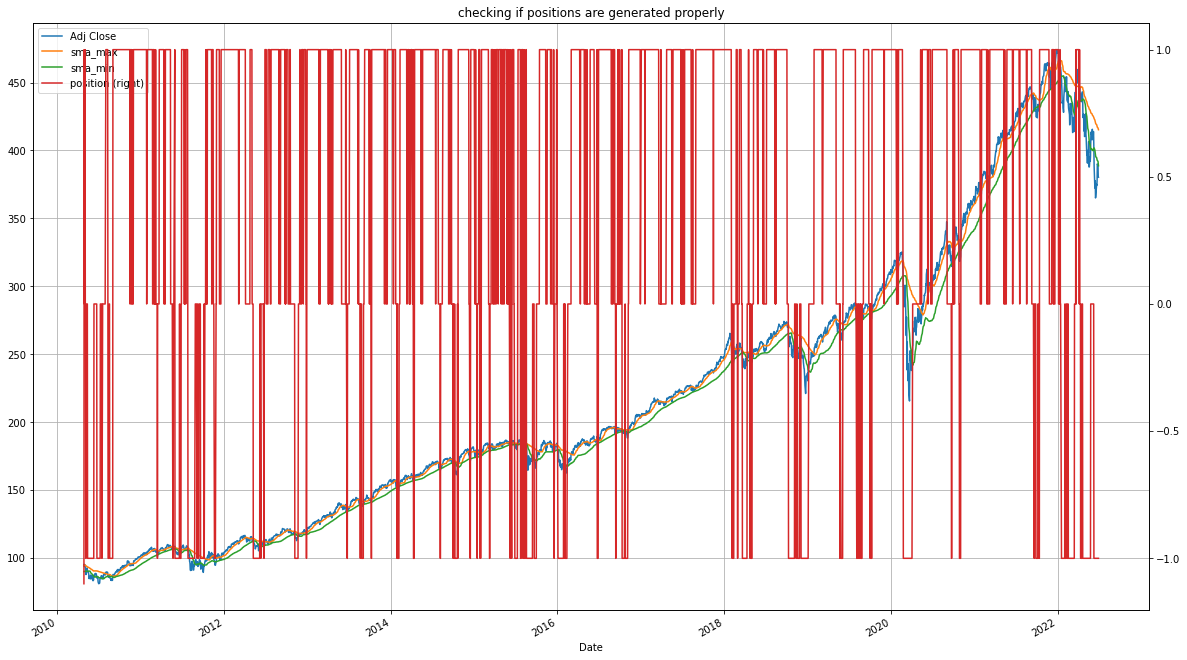

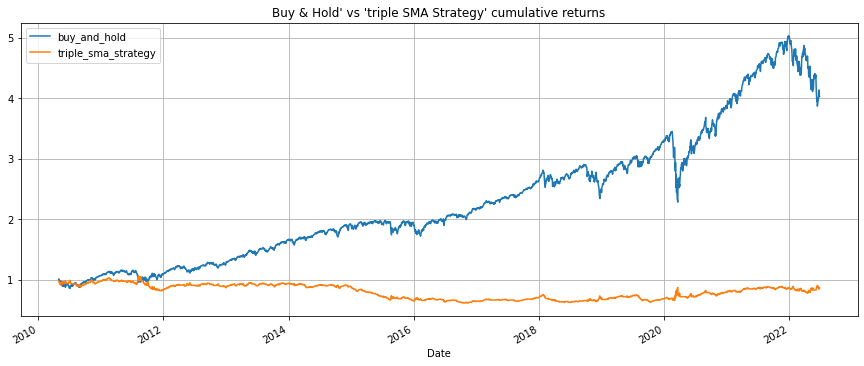

Start date,2010-04-28
End date,2022-06-29
Total months,145
,Backtest
Annual return,-1.119%
Cumulative returns,-12.795%
Annual volatility,15.099%
Sharpe ratio,0.00
Calmar ratio,-0.03
Stability,0.31
Max drawdown,-41.957%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,41.96,2011-08-08,2016-10-24,NaT,NaN
1,11.64,2010-04-28,2010-09-02,2011-01-14,188
2,10.84,2011-02-18,2011-07-27,2011-08-08,122
3,1.75,2011-01-27,2011-01-28,2011-02-04,7
4,1.11,2011-01-18,2011-01-20,2011-01-26,7


Stress Events,mean,min,max
US downgrade/European Debt Crisis,-0.08%,-4.65%,6.51%
Fukushima,-0.04%,-1.32%,0.69%
EZB IR Event,-0.03%,-1.06%,1.52%
Flash Crash,-0.73%,-4.40%,1.49%
Apr14,-0.17%,-2.10%,0.66%
Oct14,-0.03%,-1.98%,1.64%
Fall2015,0.14%,-3.84%,4.21%
Recovery,-0.02%,-4.65%,6.51%
New Normal,0.00%,-9.06%,10.94%


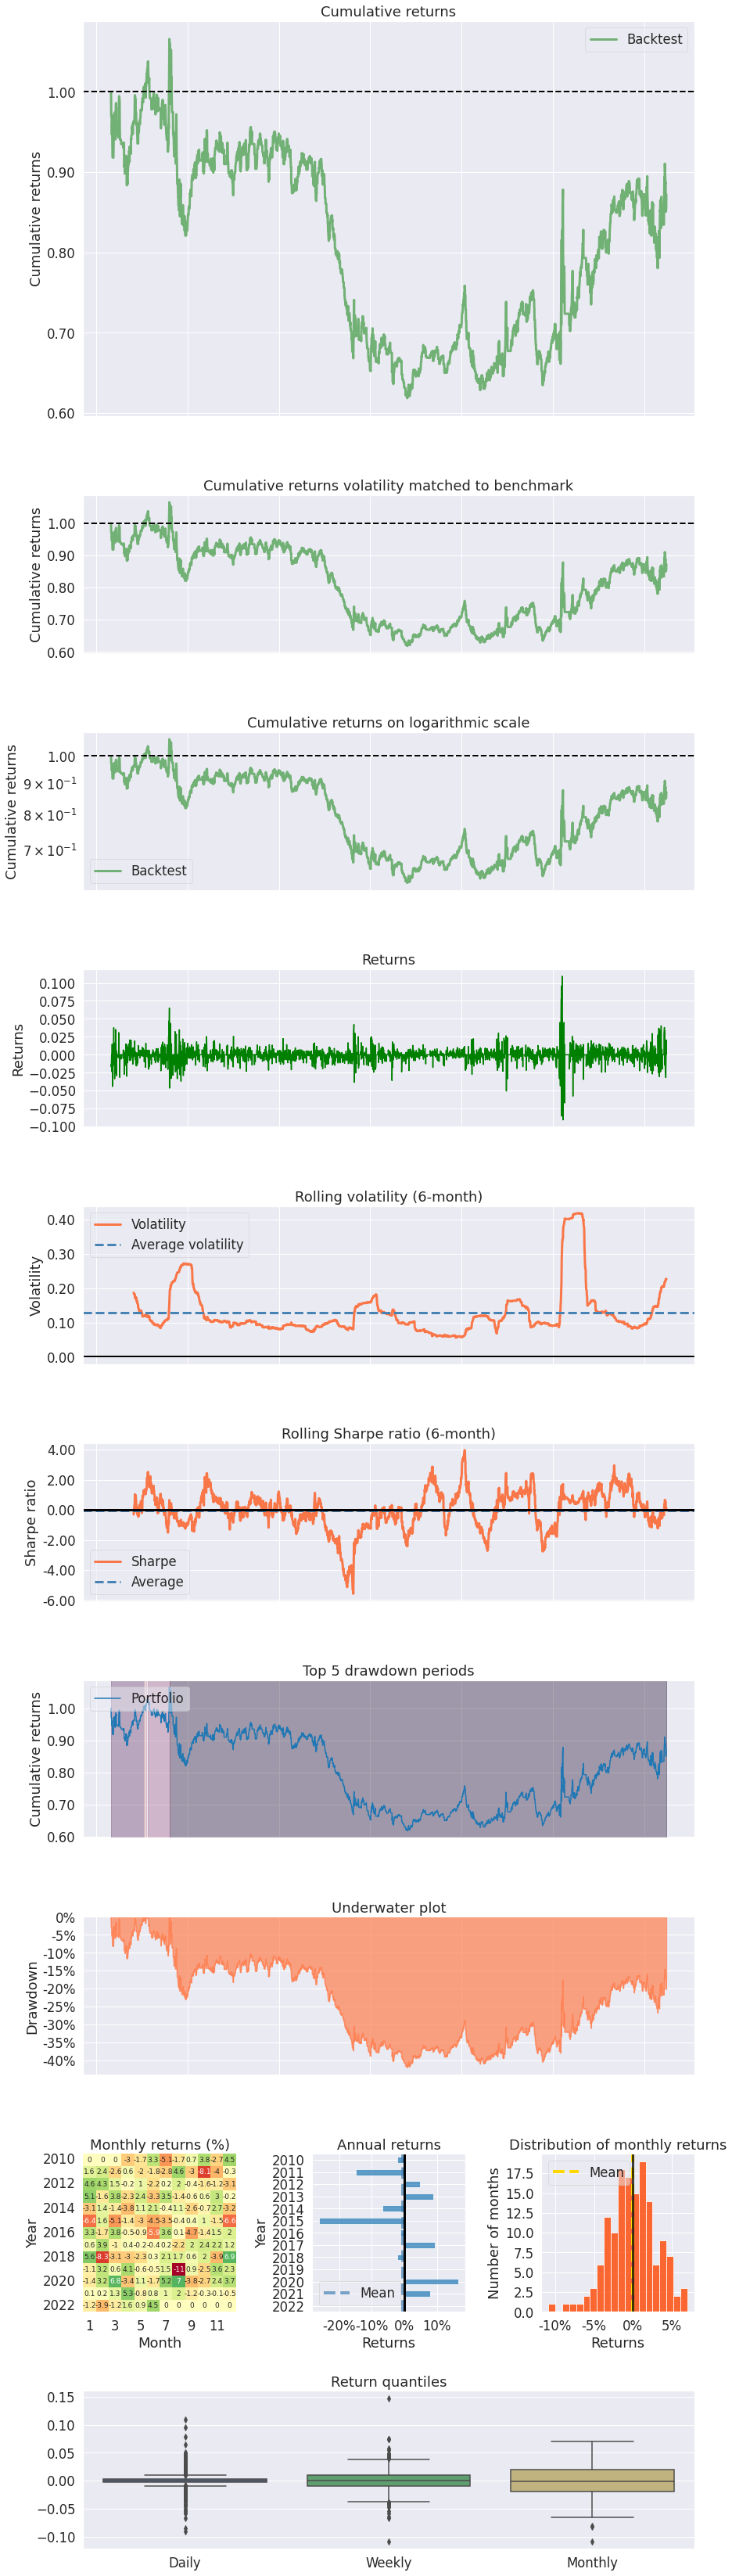

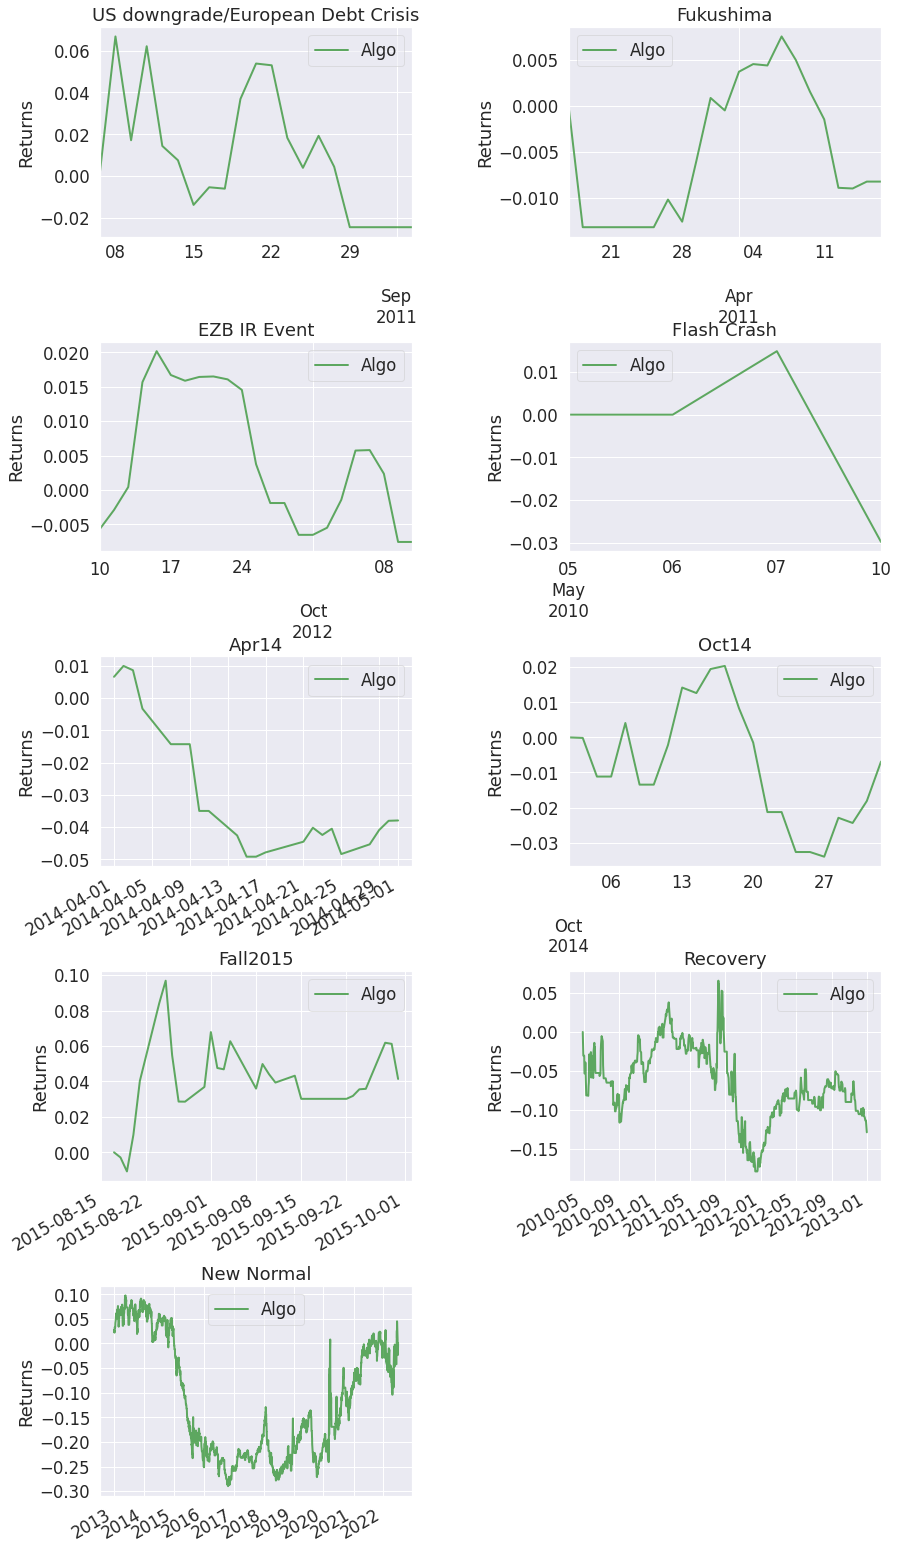

In [26]:
# Compute different metrics the strategy using pyfolio
triple_sma_strategy.analysis()

960
num of cpus being used: 15
     fast_sma  medium_sma  slow_sma  strategy_returns
434        25          85       170         33.250822
439        25          85       195         32.870647
414        25          80       170         31.734248
419        25          80       195         31.358401
403        25          80       115         30.763978
199        20          85       195         29.955773
183        20          85       115         29.740064
394        25          75       170         29.196178
423        25          85       115         29.098644
163        20          80       115         28.053871
         fast_sma  medium_sma    slow_sma  strategy_returns
count  960.000000  960.000000  960.000000        960.000000
mean    27.500000   67.500000  147.500000          2.924633
std      5.593084   17.269259   28.846435         10.577213
min     20.000000   40.000000  100.000000        -20.766905
25%     23.750000   53.750000  123.750000         -4.130953
50%     27.5000

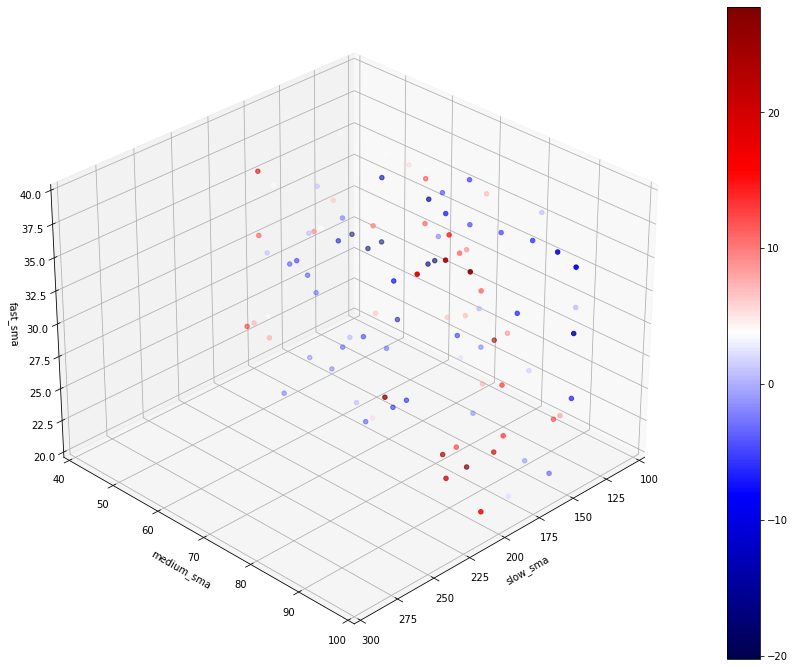

In [27]:
triple_sma_strategy.optimize_strategy(dataset)

### II. Buy and sell the next day ###
1. Buy the stock on the fourth day open, if the stock closes down consecutively for three days.
2. Exit on the next day open.
3. Optional: Optimise the strategy by exiting the long position on the same day close. Also, you can optimise the number of down days. There are high chances that the number of down days would be different for each stock.

In [8]:
# For this Trading Strategy we use vectorized backtesting

class BuySellNextDay():
    def __init__(self, df, number_of_days_down, exit_strategy, multiparallelism = False):
        self.data = df[["Adj Close", "Open"]].copy()
        self.days_down = number_of_days_down
        self.exit = exit_strategy
        self.mp = multiparallelism
        self.compute_indicators()
        self.signals(self.days_down)
        self.positions()
    
    def compute_indicators(self):
        """ 
        This method builds a number of columns equal to the number of days down required
        to compute the signal by respectively shifting the "Adj Close" by the "ddown" for loop variable
        """
        for ddown in range(self.days_down):
            self.data["prev_day" + str(ddown + 1)] = self.data["Adj Close"].shift(ddown + 1)
            
        #print(f"shape before deleting NaN values: {self.data.shape}")
        self.data.dropna(inplace=True)
        #print(f"shape after deleting NaN values: {self.data.shape}")
        #print(self.data.head())
    
    def signals(self, days_down, first= True):
        """ 
        This method calulates the signal recursively based on the required number of days
        for which we want the "Adj Close" to close down consecutively
        """
        #print("-"* 60)
        #print(days_down)
        #print(type(days_down))
        #print("-"* 60)
        
        # base case for recursion: exit when indicator reaches zero
        if days_down == 0:
            #print(self.data.head(20))
            print(self.data['signal'].value_counts())
            #print()
            #print(self.data.loc[self.data['signal'] == 1])
            return
        
        # long position enter signal
        else:
            # handle the case when numb_of_days_down is set to 1
            if first and days_down == 1:
                self.data['signal'] = np.where( (self.data['Adj Close'] \
                                                < self.data["prev_day" + str(days_down)]), 1, 0)
            elif days_down == self.days_down:
                self.data['signal'] = np.where( (self.data["prev_day" + str(days_down - 1)] \
                                                < self.data["prev_day" + str(days_down)]), 1, 0)
            elif days_down == 1:
                self.data['signal'] = np.where( (self.data['Adj Close'] < self.data["prev_day" + str(days_down)])
                                               & (self.data["signal"] == 1), 1, 0)    
            else:
                self.data['signal'] = np.where( (self.data["prev_day" + str(days_down - 1)] \
                                                < self.data["prev_day" + str(days_down)]) \
                                                & (self.data["signal"] == 1), 1, 0)
            days_down -= 1
            return self.signals(days_down, first= False)
        
    def positions(self):
        '''
        The function computes the positions
        '''
        self.data['position'] = self.data['signal']
    
    def returns(self):
        '''
        The function computes simple returns and cumulated ones for the Buy&Hold Strategy 
        and "The next day "Buy&Sell" ones
        '''
        self.data['buy_and_hold'] = self.data['Adj Close'].pct_change()
        
        # "next day open" implies to shift one day for entering the position and another day for exiting the position when we realize the return
        if self.exit == "next_day_open":
            self.data['strategy_returns'] = self.data['Open'].pct_change() * self.data['position'].shift(2)
        
         # "same day close" implies to shift one day for entering the position at the Open of the next day the arrival of the signal
        # and exiting the position at the Close of the same day or (realistically one minute before market closes)
        elif self.exit == "same_day_close":
             self.data['strategy_returns'] = ((self.data["Adj Close"] - self.data["Open"]) / self.data["Open"]) * self.data['position'].shift(1)
        else:
            print("error in specifying the exit strategy")
        
        # when doimg optimization through MultiProcessing we do not need to print info
        if not self.mp:
            print("\n")
            print("-" * 60)
            print(f"Num. of days down: {self.days_down}, Exit: {self.exit}")
            print(f"Buy&Hold returns (simple): {((1 + self.data['buy_and_hold']).cumprod()[-1] -1) * 100:.2f}%")
            print(f"Strategy returns (simple): {((1 + self.data['strategy_returns']).cumprod()[-1] -1) * 100:.2f}%")
            #print(self.data.head(20))
        
        else:
            buy_and_hold_return = ((1 + self.data['buy_and_hold']).cumprod()[-1] -1) * 100
            strategy_return = ((1 + self.data['strategy_returns']).cumprod()[-1] -1) * 100     
            
            return (self.days_down, self.exit, buy_and_hold_return, strategy_return)
        
        
    def analysis(self):
        '''
        The function checks whether positions are generated properly and compares returns of Buy&Hold Strategy 
        and the Strategy using plots
        '''
        # A plot to check if the strategy is working as planned:
        self.data[["Adj Close", "Open", 'position']].plot(figsize=(20, 12), secondary_y='position', grid=True);
        plt.title('checking if positions are generated properly')
        plt.show()
        
        # A plot to check how the strategy strategy performs relative to buy & hold
        self.data['buy_and_hold'] = 1 + self.data['buy_and_hold']
        self.data['strategy_returns'] = 1 + self.data['strategy_returns']
        self.data[['buy_and_hold','strategy_returns']].cumprod().plot(figsize=(15, 6), grid=True)
        plt.title("Buy & Hold' vs 'strategy_returns' cumulative returns")
        plt.show()
        
        # General analytics
        pf.create_full_tear_sheet(self.data["strategy_returns"] -1, benchmark_rets=None)
    
    
    def optimize_strategy(self, raw_data):
        '''
        The function uses multiprocessing (this is a CPU-bound job) to optimize in parallel different combuinations
        of parameters: numb.of days down and different exit strategies.
        '''
        
        # grid-search with brute force using multi-processing
        # here we define the range of the parameters in order to optimize the strategy
        exit = ["next_day_open", "same_day_close"]
        days_down = [1, 6]
        step_size = 1
        
        days_down_range = list(np.arange(days_down[0], days_down[1], step_size))
        param_combinations = list(product(*[days_down_range, exit])) 
        #print(param_combinations)
            
        prepared_list = []
        for i in range(len(param_combinations)):
            prepared_list.append((raw_data, param_combinations[i][0], param_combinations[i][1], True))
            #print([param_combinations[i][0], param_combinations[i][1]])

        start_time = time()
        # I've got 16 CPU on my PC
        print(f"num of cpus being used: {max(1, cpu_count() - 1)}")
        with Pool(processes = max(1, cpu_count() - 1)) as mp_pool:
            results = mp_pool.starmap(BuySellNextDay, prepared_list)
            
        num_of_days_down_list = []
        exit_list = []
        buy_and_hod_returns = []
        strategy_returns = []
        
        for res in results:
            v = res.returns()
            #print(v)
            num_of_days_down_list.append(v[0]), exit_list.append(v[1])
            buy_and_hod_returns.append(v[2]), strategy_returns.append(v[3])
            
        # Convert into a DataFrame
        df_results = pd.DataFrame({'num_of_days_down':num_of_days_down_list, 'exit': exit_list, \
                                   'strategy_returns': strategy_returns})
        print(df_results.sort_values(by= 'strategy_returns', ascending=False).head(10))
        print()
        print(df_results.describe())
       
        
        print(f"\nEverything took {(time() -  start_time):.2f} sec. to complete")

In [9]:
dataset =raw_data.copy()
number_of_days_down = 3
exit_strategy = "next_day_open" # options: "same_day_close", "next_day_open"
buysellnextday = BuySellNextDay(dataset, number_of_days_down, exit_strategy)

0    2891
1     251
Name: signal, dtype: int64


In [10]:
#calculate the returns for the chosen strategy
buysellnextday.returns()



------------------------------------------------------------
Num. of days down: 3, Exit: next_day_open
Buy&Hold returns (simple): 324.84%
Strategy returns (simple): 19.34%


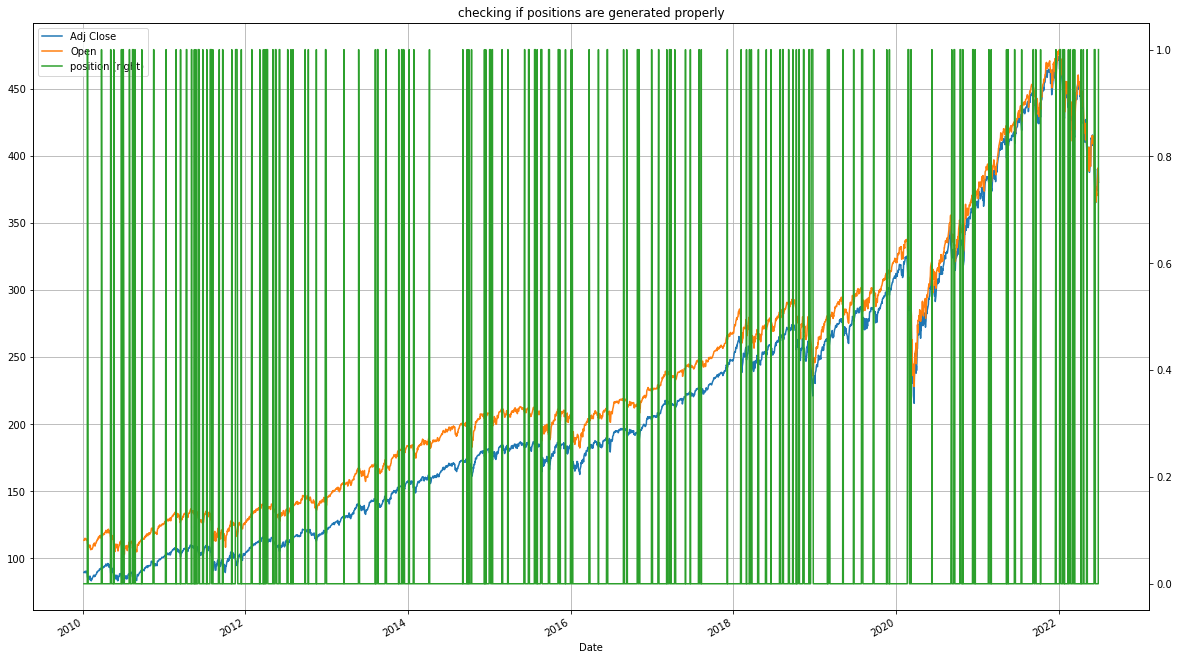

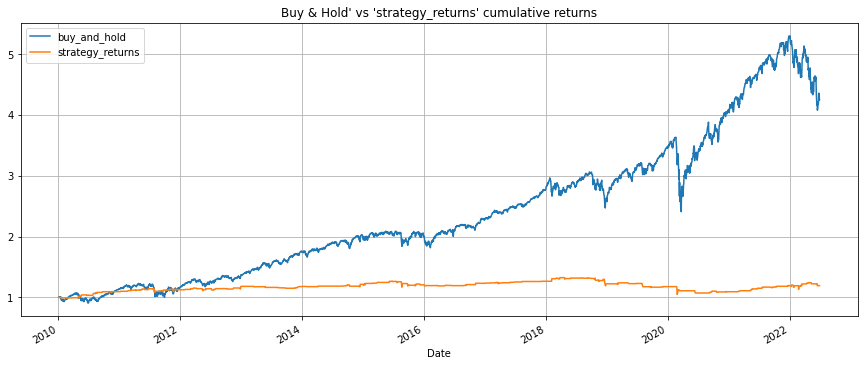

Start date,2010-01-06
End date,2022-06-29
Total months,149
,Backtest
Annual return,1.428%
Cumulative returns,19.342%
Annual volatility,6.317%
Sharpe ratio,0.26
Calmar ratio,0.07
Stability,0.16
Max drawdown,-20.789%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,20.79,2018-04-24,2020-02-28,NaT,NaN
1,7.63,2015-06-29,2015-08-24,2017-12-07,639
2,4.91,2011-08-01,2011-08-04,2012-03-26,171
3,3.81,2012-03-30,2012-05-21,2012-11-19,167
4,2.61,2013-03-20,2013-09-27,2014-04-09,276


Stress Events,mean,min,max
US downgrade/European Debt Crisis,0.05%,0.00%,1.04%
Fukushima,0.03%,-1.04%,0.84%
EZB IR Event,0.00%,-0.12%,0.14%
Flash Crash,0.70%,0.00%,2.81%
Apr14,0.03%,0.00%,0.73%
Oct14,-0.04%,-1.73%,0.77%
Fall2015,-0.13%,-7.06%,4.23%
Recovery,0.02%,-2.32%,2.81%
New Normal,0.00%,-7.06%,4.52%


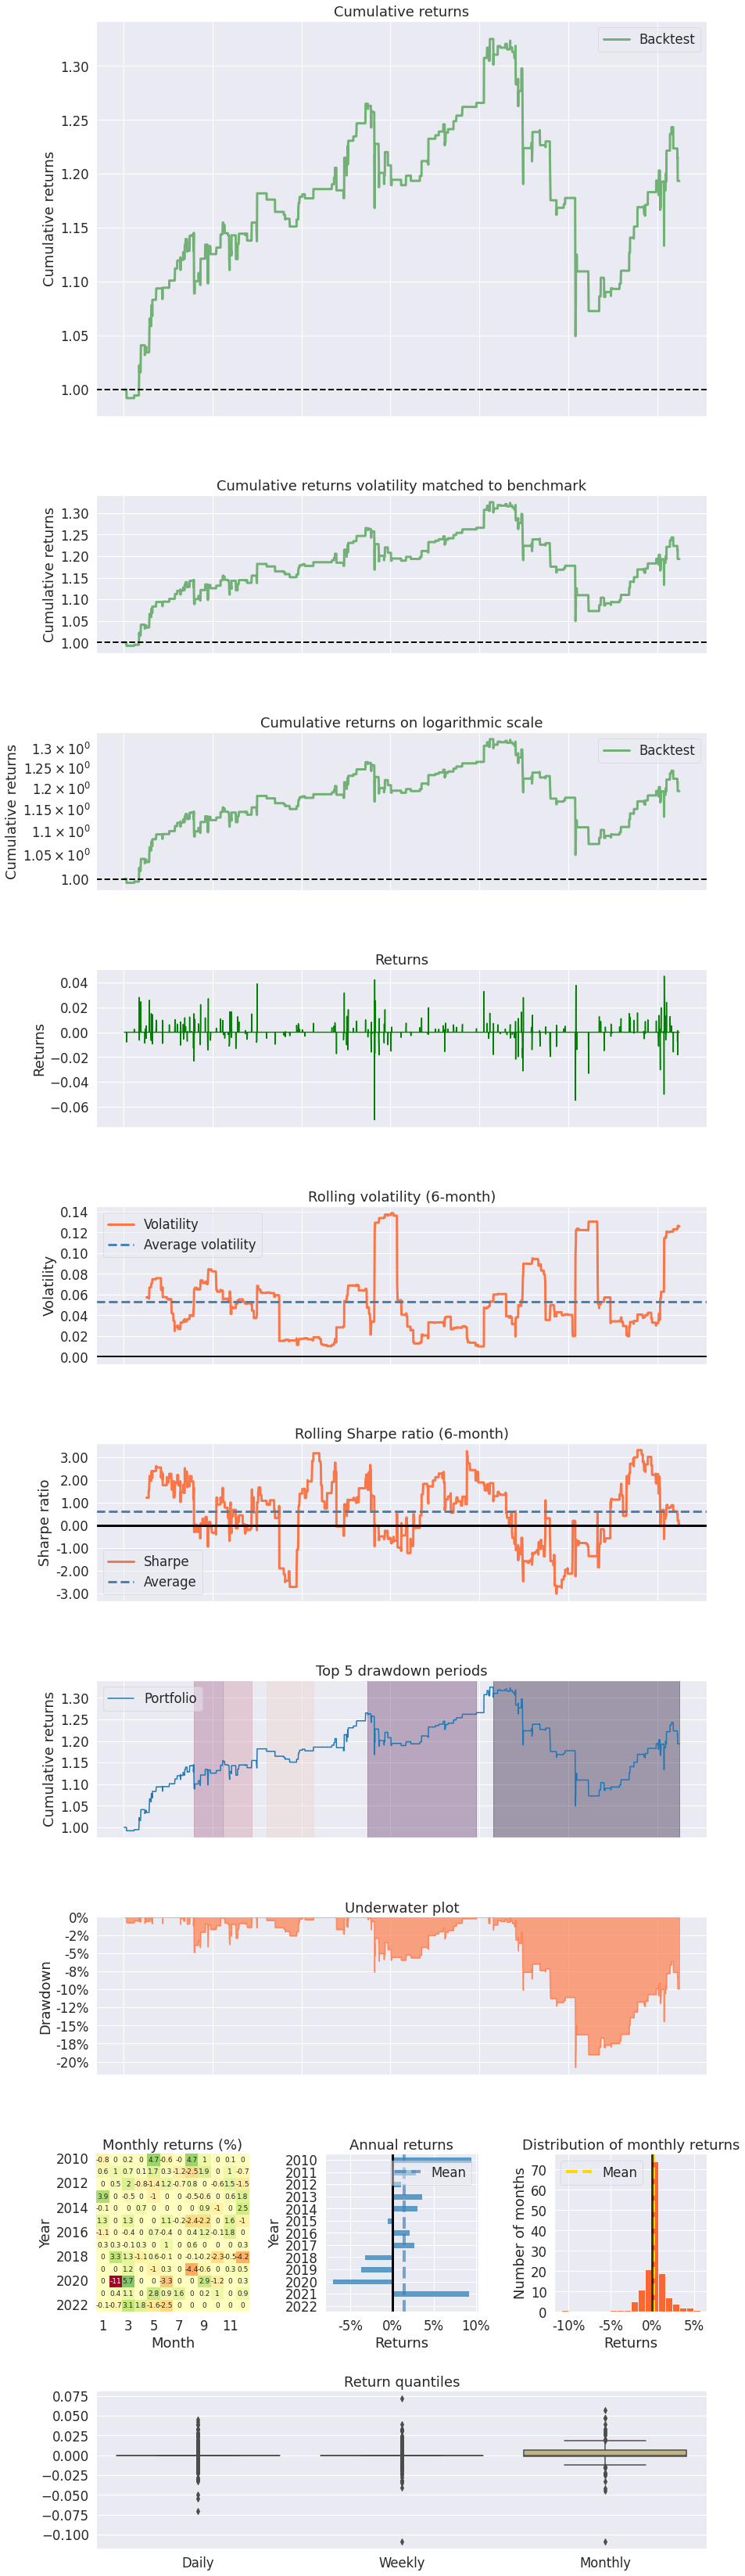

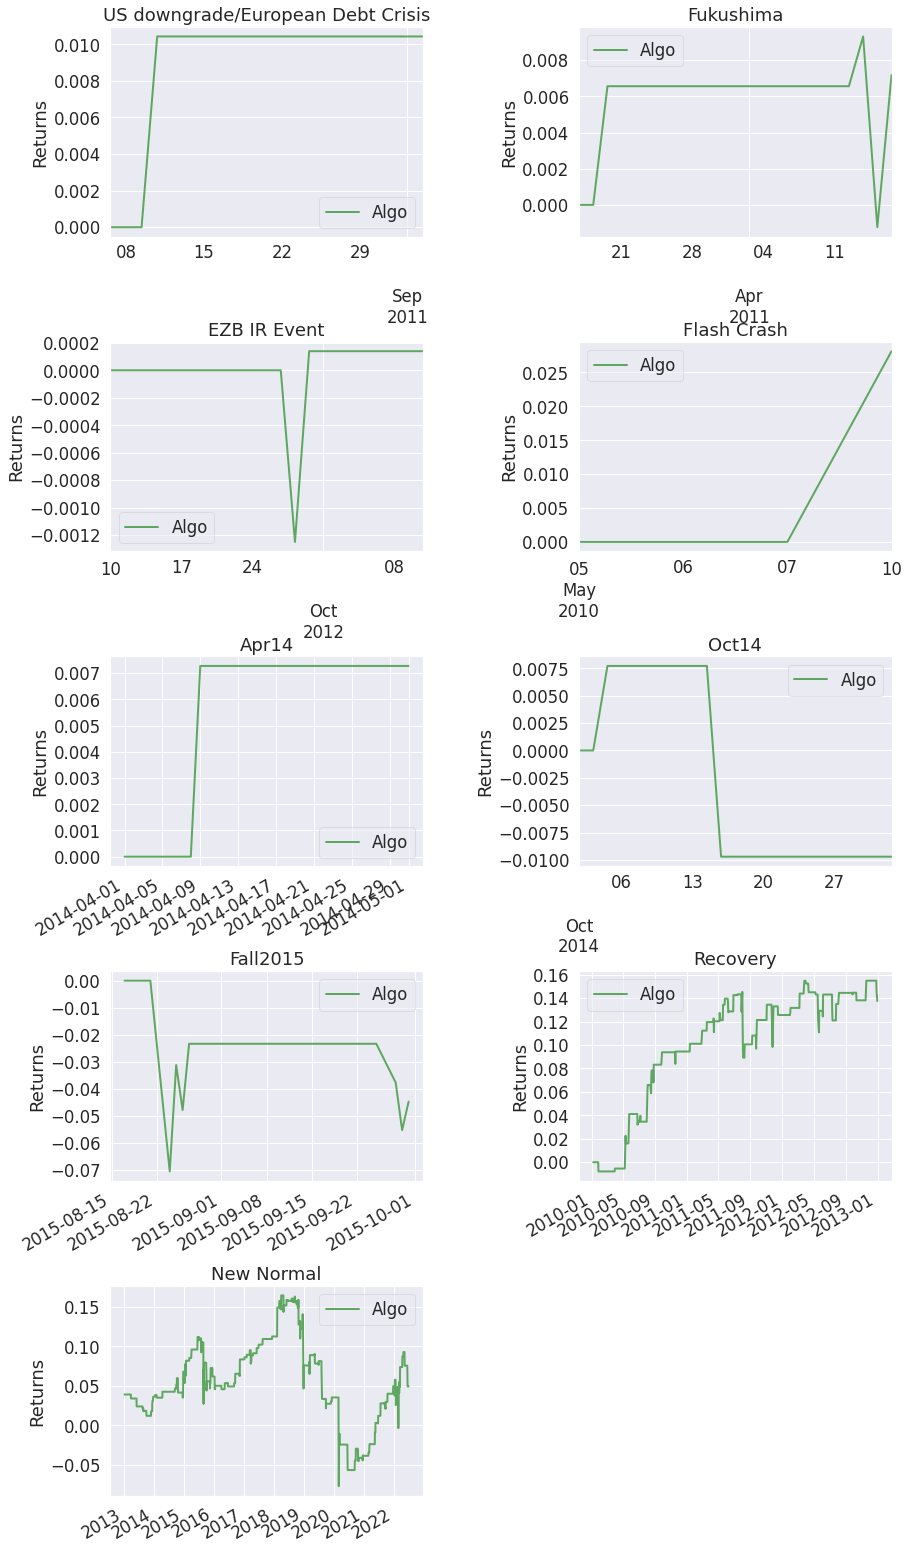

In [11]:
# Compute different metrics the strategy using pyfolio
buysellnextday.analysis()

In [12]:
# parameter optimization
buysellnextday.optimize_strategy(dataset)

num of cpus being used: 15
0    1755
1    1389
Name: signal, dtype: int640    1755
1    1389
Name: signal, dtype: int64

0    2552
1     591
Name: signal, dtype: int640    2552
1     591
Name: signal, dtype: int640    2891
1     251
Name: signal, dtype: int640    2891
1     251
Name: signal, dtype: int64



0    3038
1     103
Name: signal, dtype: int640    3038
1     103
Name: signal, dtype: int640    3100
1      40
Name: signal, dtype: int64


0    3100
1      40
Name: signal, dtype: int64
   num_of_days_down            exit  strategy_returns
0                 1   next_day_open         50.591178
2                 2   next_day_open         33.809763
4                 3   next_day_open         19.342403
6                 4   next_day_open         12.029569
8                 5   next_day_open          6.034479
9                 5  same_day_close        -99.312014
7                 4  same_day_close        -99.999627
5                 3  same_day_close       -100.000000
1                

### Strategy based on RSI indicator ###
1. Buy the instrument such as Nifty or SPY when the RSI is less than 15
2. Exit conditions: <br>
    a. Take profit of 5% or RSI > 75  <br>
    b. Stop loss of - 2%
3. Optional: Optimise the strategy by adjusting the RSI value. Also, take profit and stoploss criteria can be different for each stock.
4. Note: You can use TA-Lib in Python to compute the RSI value.

In [13]:
asset= "SPY"
start_date = datetime(2010, 1, 1)
end_date = datetime(2022, 6, 30)
raw_data = download_data(asset, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close    Volume
Date                                                                            
2022-06-23  376.640015  378.829987  372.890015  378.059998  378.059998  79292100
2022-06-24  381.399994  390.089996  381.369995  390.079987  390.079987  98050300
2022-06-27  391.049988  391.359985  387.440002  388.589996  388.589996  66009600
2022-06-28  390.230011  393.160004  380.529999  380.649994  380.649994  86548900
2022-06-29  381.230011  382.269989  378.420013  380.339996  380.339996  65676000
(3145, 6)
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
shape with NaN values: (3145, 6)
shape after deleting NaN values: (3145, 6)


In [14]:
# For this Trading Strategy we use the event-based backtesting paradigm

class RSI_Strategy():
    def __init__(self, df, buy_rsi, tp_rsi, take_profit, stop_loss, multiparallelism = False):
        self.data = df[["Adj Close"]].copy()
        self.buy_rsi = buy_rsi
        self.tp_rsi = tp_rsi
        self.take_profit = take_profit
        self.stop_loss = stop_loss
        self.mp = multiparallelism
        self.trades = 0
        self.position = 0
        self.starting_price = None
        
        self.prepare_statistics()
        self.backtest_strategy()
        self.returns()
    
    def get_date_price(self, bar):
        '''
        This method generates date and price for a specific bar
        '''
        date, price  = str(self.data.index[bar])[:10], self.data["Adj Close"].iloc[bar]
        return date, price
    
    def place_buy_order(self, bar):
        '''
        This method place a buy order ans set open_position to 1 so that only one buy order can be open
        at the same time
        '''
        date, price = self.get_date_price(bar)
        self.trades += 1
        self.position = 1
        self.starting_price = price
        self.data["signal"].iloc[bar] = 1
        if not self.mp:
            print(f"{date} | bought 1 unit for price: {price:.3f}")
    
    def close_out(self, bar):
        '''
        This method squares off a buy order and sets open_position to 0 so that a new buy order can be opened
        if conditions are met
        '''
        date, price = self.get_date_price(bar)
        self.position = 0
        self.data["strategy_returns"].iloc[bar] = (price - self.starting_price) / self.starting_price
        self.data["signal"].iloc[bar] = 0
        if not self.mp:
            print(f"{date} | closing out buy order at price: {price:.3f}")
            print()
    
    def prepare_statistics(self):
        """ 
        This method builds a number of columns required to compute the signals to enter/exit the position
        """
        self.data["rsi"] = RSI(self.data["Adj Close"])
        # empty columns used for ex-post analysis 
        self.data["strategy_returns"] = 0
        self.data["signal"] = -1
        #print(self.data)
    
    def backtest_strategy(self):
        """ 
        This method builds backtest the strategy in ana event-driven fashion
        """
        # we start from 14 since the standard RSI indicator is calculated based on the last 14 bars
        for bar in range(14, len(self.data)):
            date, price = self.get_date_price(bar)
            
            # check if exit conditions are met:
            if self.position == 1:
                take_profit1 = ((price - self.starting_price) / self.starting_price) * 100 >=  self.take_profit
                take_profit2 = self.data["rsi"].iloc[bar] >= self.tp_rsi
                stop_loss = ((price - self.starting_price) / self.starting_price) * 100 <=  self.stop_loss
            
            # square off position if conditions are met
            if self.position == 1 and (take_profit1 or take_profit2 or stop_loss):
                if not self.mp:
                    if take_profit1:
                        print(f"{date} | closing position for take profit: {(((price - self.starting_price) / self.starting_price) * 100):.2f}%")
                    elif take_profit2:
                        print(f"{date} | closing position for RSI: {self.data['rsi'].iloc[bar]}")
                    elif stop_loss:
                        print(f"{date} | closing position for loss: {(((price - self.starting_price) / self.starting_price) * 100):.2f}%")
                    
                self.close_out(bar)
            
            # enter long position if no position is already open and RSI satisfies our condition
            if self.position == 0 and self.data["rsi"].iloc[bar] < self.buy_rsi:
                self.place_buy_order(bar)
        
        # close position just in case on the last bar there is still an open trade:
        self.close_out(bar) if self.position == 1 else None
    
    def returns(self):
        '''
        The function computes simple returns and cumulated ones for the "Buy & Hold" Strategy 
        and "RSI" ones
        '''
        
        self.data["position"] = self.data["signal"].replace(to_replace= -1, method= "ffill")
        
        self.data['buy_and_hold'] = self.data['Adj Close'].pct_change()
        self.data['stretegy_returns'] = self.data['buy_and_hold'] * self.data["position"].shift(1)
        
        # when doing optimization through MultiProcessing we do not need to print info
        if not self.mp:
            print("\n")
            print("-" * 60)
            print(f"RSI buy: {self.buy_rsi}, RSI TP: {self.tp_rsi}, TP: {self.take_profit}%, SL: {self.stop_loss}%")
            print(f"Buy & Hold returns (simple): {((1 + self.data['buy_and_hold']).cumprod()[-1] -1) * 100:.2f}%")
            print(f"Strategy returns (simple): {((1 + self.data['strategy_returns']).cumprod()[-1] -1) * 100:.2f}%")
            #print(self.data.head(20))
        
        else:
            buy_and_hold_return = ((1 + self.data['buy_and_hold']).cumprod()[-1] -1) * 100
            strategy_return = ((1 + self.data['strategy_returns']).cumprod()[-1] -1) * 100     
            
            return (self.buy_rsi, self.tp_rsi, self.take_profit, self.stop_loss, buy_and_hold_return, strategy_return)
        
    
    def analysis(self):
        '''
        The function checks whether positions are generated properly and compares returns of "Buy & Hold" Strategy 
        and the one in question using plots
        '''
        # A plot to check if the strategy is working as planned:
        self.data[["rsi",'position']].plot(figsize=(15, 10), secondary_y='position', grid=True);
        plt.title('checking if positions are generated properly')
        plt.show()
        
        # A plot to check how the strategy strategy performs relative to buy & hold
        self.data['buy_and_hold'] = 1 + self.data['buy_and_hold']
        self.data['strategy_returns'] = 1 + self.data['strategy_returns']
        self.data[['buy_and_hold','strategy_returns']].cumprod().plot(figsize=(15, 6), grid=True)
        plt.title("Buy & Hold' vs 'strategy_returns' cumulative returns")
        plt.show()
        
        # General analytics
        pf.create_full_tear_sheet(self.data["strategy_returns"] -1, benchmark_rets=None)
    
    def optimize_strategy(self):
        '''
        The function uses multiprocessing (this is a CPU-bound job) to optimize in parallel different combuinations
        of parameters: buy_rsi, tp_rsi, tp_percent and sl_percent.
        '''
        
        # grid-search with brute force using multi-processing
        # here we define the range of the parameters in order to optimize the strategy
        buy_rsi = [12, 20]
        tp_rsi = [72, 80]
        tp_percent = [3, 5]
        sl_percent = [-2, -1]
        
        step_size = 1
        
        buy_rsi_range= list(np.arange(buy_rsi[0], buy_rsi[1], step_size))
        tp_rsi_range = list(np.arange(tp_rsi[0], tp_rsi[1], step_size))
        tp_percent_range = list(np.arange(tp_percent[0], tp_percent[1], step_size))
        sl_percent_range = list(np.arange(sl_percent[0], sl_percent[1], step_size))
        param_space = list(product(*[buy_rsi_range, tp_rsi_range, tp_percent_range, sl_percent_range])) 
        
        print(f"Combinations to optimize: {len(param_space)}")
        
        prepared_list = []
        for i in range(len(param_space)):
            prepared_list.append((raw_data, param_space[i][0], param_space[i][1], param_space[i][2], param_space[i][3], True))
            #print(param_space[i][0], param_space[i][1], param_space[i][2], param_space[i][3])
            
        
        start_time = time()
        # I've got 16 CPU on my PC
        print(f"num of cpus being used: {max(1, cpu_count() - 1)}")
        with Pool(processes = max(1, cpu_count() - 1)) as mp_pool:
            results = mp_pool.starmap(RSI_Strategy, prepared_list)
            
        buy_rsi_list = []
        tp_rsi_list = []
        tp_percent_list = []
        sl_percent_list = []
        buy_and_hod_returns = []
        strategy_returns = []
        
        for res in results:
            v = res.returns()
            #print(v)
            buy_rsi_list.append(v[0]), tp_rsi_list.append(v[1]), tp_percent_list.append(v[2]), sl_percent_list.append(v[3])
            buy_and_hod_returns.append(v[4]), strategy_returns.append(v[5])
            
        # Convert into a DataFrame
        df_results = pd.DataFrame({'buy_rsi': buy_rsi_list, 'tp_rsi': tp_rsi_list, \
                                   'tp_percent': tp_percent_list, 'sl_percent': sl_percent_list, \
                                   'strategy_returns': strategy_returns})
        
        print(df_results.sort_values(by= 'strategy_returns', ascending=False).head(10))
        print()
        print(df_results.describe())
       
        print(f"\nEverything took {(time() -  start_time):.2f} sec. to complete")

In [15]:
# HERE: we can change the parameters for the specific trading strategy
dataset =raw_data.copy()
buy_rsi = 30
tp_rsi = 60
take_profit_percent = 3
stop_loss_percent = -1
rsi_strategy = RSI_Strategy(dataset, buy_rsi, tp_rsi, take_profit_percent, stop_loss_percent)

2011-08-04 | bought 1 unit for price: 97.440
2011-08-08 | closing position for loss: -6.65%
2011-08-08 | closing out buy order at price: 90.958

2011-08-08 | bought 1 unit for price: 90.958
2011-08-09 | closing position for take profit: 4.65%
2011-08-09 | closing out buy order at price: 95.188

2011-08-10 | bought 1 unit for price: 90.983
2011-08-11 | closing position for take profit: 4.49%
2011-08-11 | closing out buy order at price: 95.066

2012-05-17 | bought 1 unit for price: 107.723
2012-06-01 | closing position for loss: -2.06%
2012-06-01 | closing out buy order at price: 105.501

2012-06-01 | bought 1 unit for price: 105.501
2012-06-07 | closing position for take profit: 3.04%
2012-06-07 | closing out buy order at price: 108.703

2012-11-14 | bought 1 unit for price: 113.077
2012-11-23 | closing position for take profit: 3.99%
2012-11-23 | closing out buy order at price: 117.586

2014-10-15 | bought 1 unit for price: 161.563
2014-10-21 | closing position for take profit: 4.10%
2

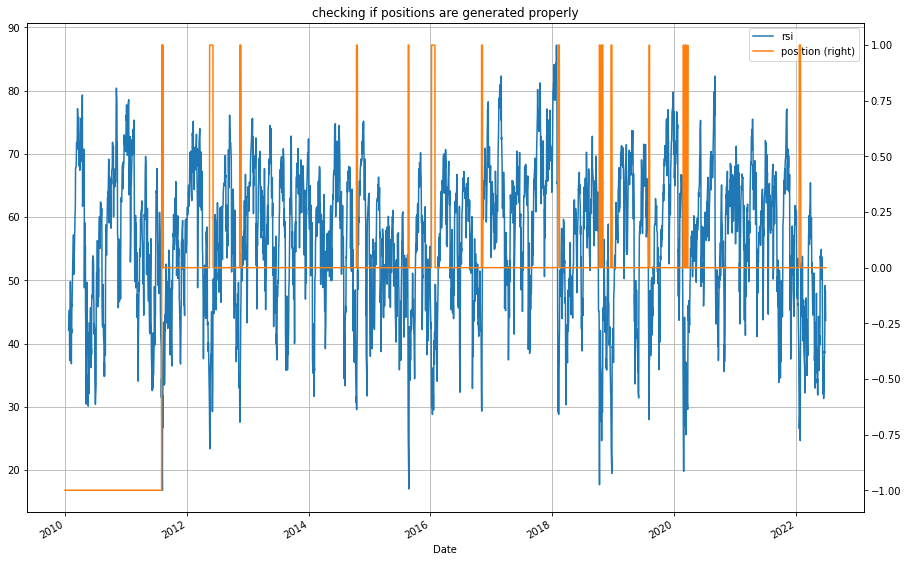

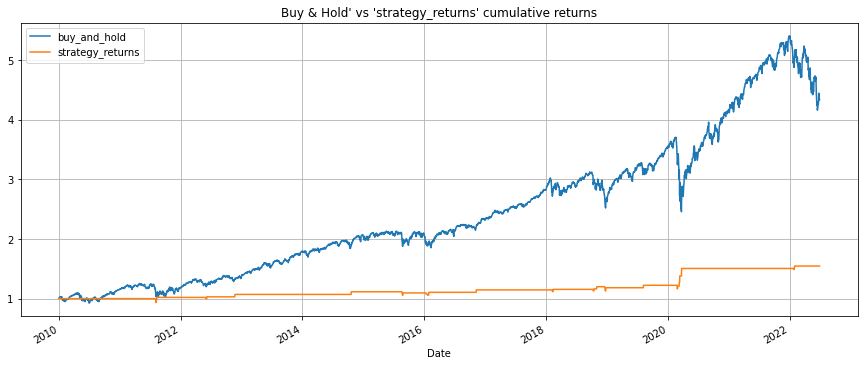

Start date,2009-12-31
End date,2022-06-29
Total months,149
,Backtest
Annual return,3.559%
Cumulative returns,54.72%
Annual volatility,6.519%
Sharpe ratio,0.57
Calmar ratio,0.54
Stability,0.82
Max drawdown,-6.652%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,6.65,2011-08-05,2011-08-08,2011-08-11,5
1,6.19,2018-12-19,2018-12-24,2019-08-08,167
2,5.34,2015-08-21,2015-08-25,2016-11-09,319
3,4.84,2020-02-26,2020-02-27,2020-03-10,10
4,2.39,2018-02-07,2018-02-08,2018-02-13,5


Stress Events,mean,min,max
US downgrade/European Debt Crisis,0.12%,-6.65%,4.65%
Fukushima,0.00%,0.00%,0.00%
EZB IR Event,0.00%,0.00%,0.00%
Flash Crash,0.00%,0.00%,0.00%
Apr14,0.00%,0.00%,0.00%
Oct14,0.18%,0.00%,4.10%
Fall2015,-0.05%,-4.21%,3.84%
Recovery,0.01%,-6.65%,4.65%
New Normal,0.02%,-4.84%,9.06%


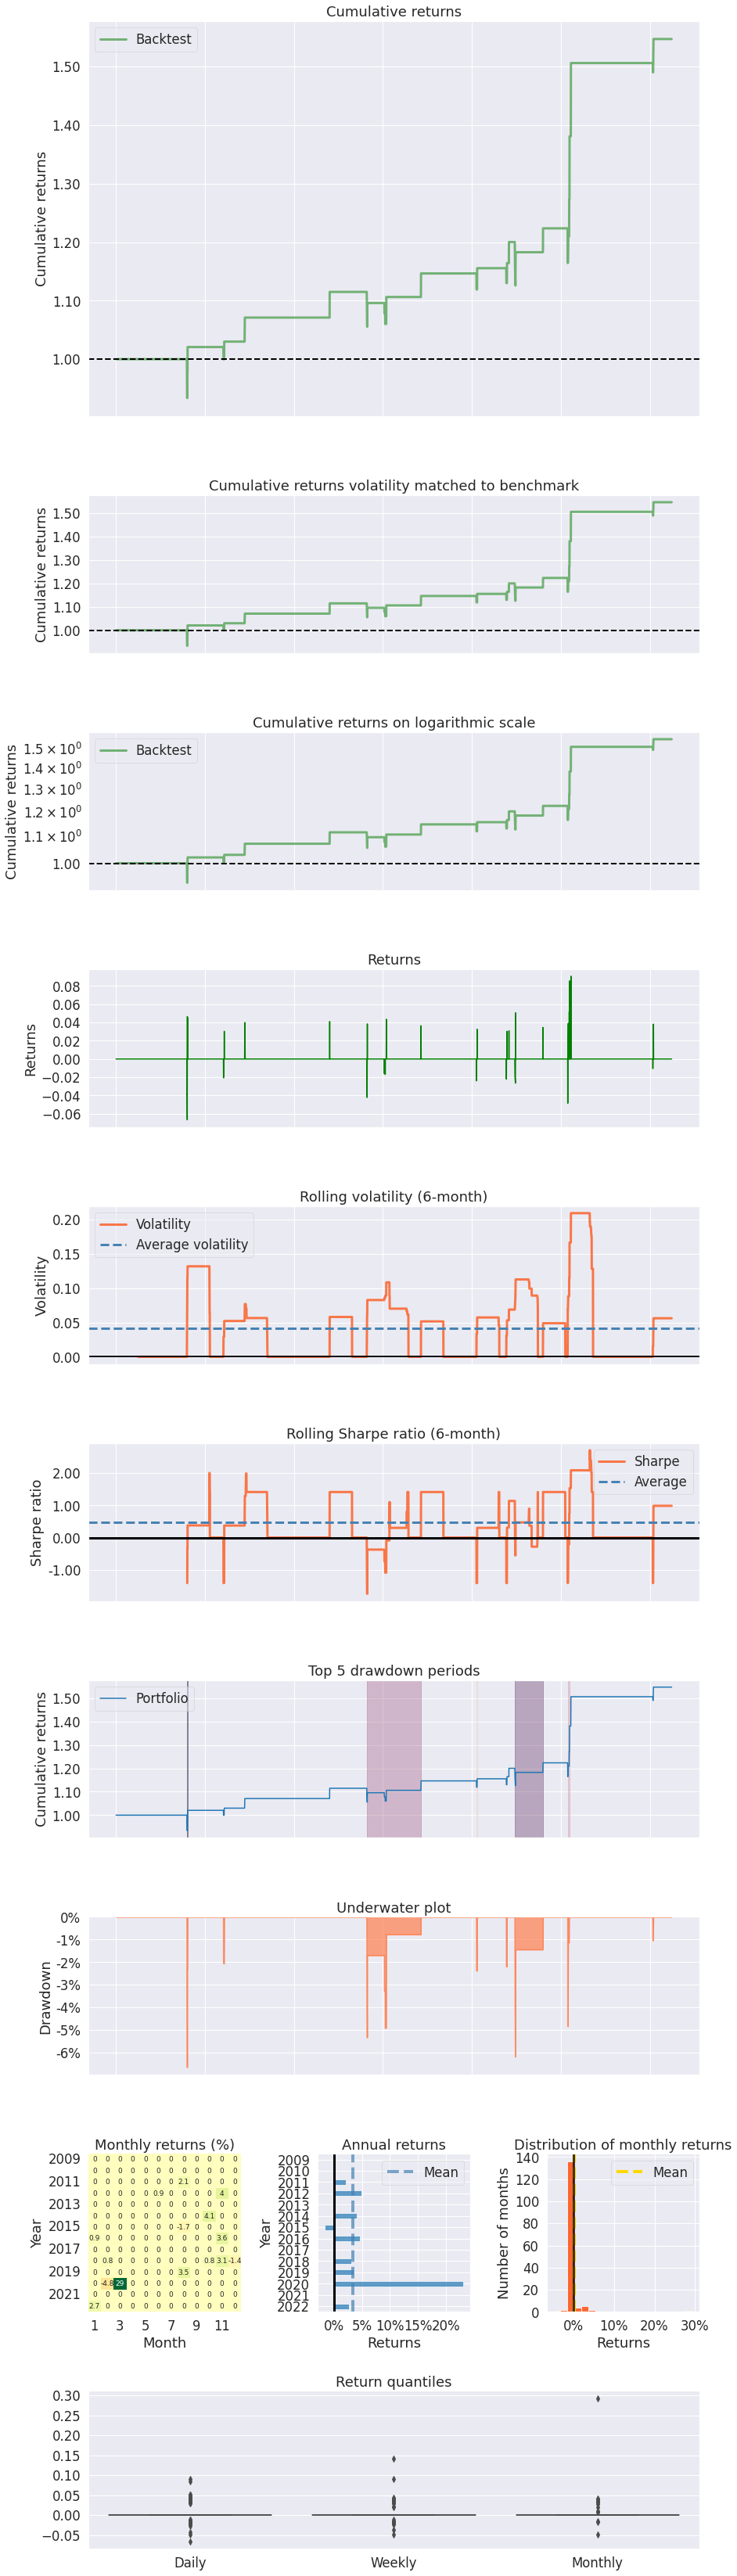

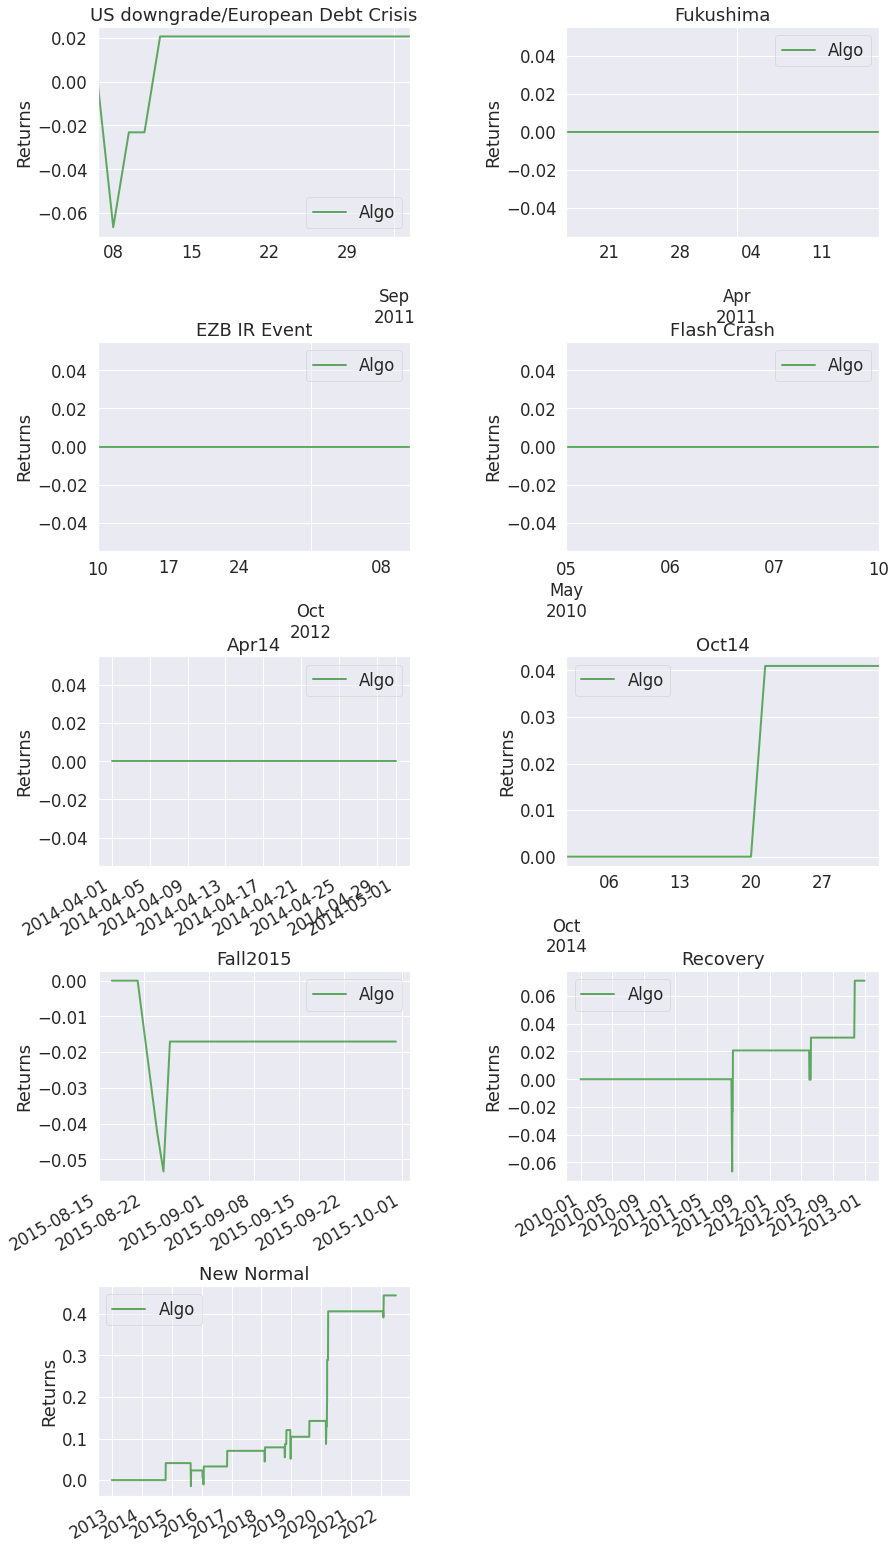

In [16]:
# Compute different metrics the strategy using pyfolio
rsi_strategy.analysis()

In [28]:
# parameter optimization
rsi_strategy.optimize_strategy()

Combinations to optimize: 128
num of cpus being used: 15
     buy_rsi  tp_rsi  tp_percent  sl_percent  strategy_returns
112       19      72           3          -2         13.372925
126       19      79           3          -2         13.372925
124       19      78           3          -2         13.372925
122       19      77           3          -2         13.372925
120       19      76           3          -2         13.372925
118       19      75           3          -2         13.372925
116       19      74           3          -2         13.372925
114       19      73           3          -2         13.372925
96        18      72           3          -2         11.953776
98        18      73           3          -2         11.953776

          buy_rsi      tp_rsi  tp_percent  sl_percent  strategy_returns
count  128.000000  128.000000  128.000000       128.0        128.000000
mean    15.500000   75.500000    3.500000        -2.0          3.823696
std      2.300291    2.300291    

### Backtest the strategy based on the turtle trading system covered in EFS-02 class. ###
You can use the daily data for backtesting purpose. Also, the event-driven approach covered in DMP-01 and DMP-03 would be best for this scenario. <br>
Backtest a strategy based on a high & low price
1. Go long when the stock closes above the last 20 day’s high price.
2. Square off the long position when the stock goes below the last 20 day’s low price.
3. Optional: Optimise the strategy by adjusting the number of periods. You can choose to have different number of periods for entering the long and exiting the long.

In [18]:
asset= "SPY"
start_date = datetime(2010, 1, 1)
#end_date = datetime(2020, 12, 31)
end_date = datetime(2022, 6, 30)
raw_data = download_data(asset, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close    Volume
Date                                                                            
2022-06-23  376.640015  378.829987  372.890015  378.059998  378.059998  79292100
2022-06-24  381.399994  390.089996  381.369995  390.079987  390.079987  98050300
2022-06-27  391.049988  391.359985  387.440002  388.589996  388.589996  66009600
2022-06-28  390.230011  393.160004  380.529999  380.649994  380.649994  86548900
2022-06-29  381.230011  382.269989  378.420013  380.339996  380.339996  65676000
(3145, 6)
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
shape with NaN values: (3145, 6)
shape after deleting NaN values: (3145, 6)


In [19]:
# For this Trading Strategy we use the event-based backtesting paradigm

class Turtle_Strategy():
    def __init__(self, df, lookback_high, lookback_low, multiparallelism = False):
        self.data = df[["Adj Close"]].copy()
        self.lookback_high = lookback_high
        self.lookback_low = lookback_low
        self.mp = multiparallelism
        self.trades = 0
        self.position = 0
        self.starting_price = None
        
        self.prepare_statistics()
        self.backtest_strategy()
        self.returns()
    
    def get_date_price(self, bar):
        '''
        This method generates date and price for a specific bar
        '''
        date, price  = str(self.data.index[bar])[:10], self.data["Adj Close"].iloc[bar]
        return date, price
    
    def place_buy_order(self, bar):
        '''
        This method place a buy order ans set open_position to 1 so that only one buy order can be open
        at the same time
        '''
        date, price = self.get_date_price(bar)
        self.trades += 1
        self.position = 1
        self.starting_price = price
        self.data["signal"].iloc[bar] = 1
        if not self.mp:
            print(f"{date} | bought 1 unit for price: {price:.3f}")
    
    def close_out(self, bar):
        '''
        This method squares off a buy order and sets open_position to 0 so that a new buy order can be opened
        if conditions are met
        '''
        date, price = self.get_date_price(bar)
        self.position = 0
        self.data["strategy_returns"].iloc[bar] = (price - self.starting_price) / self.starting_price
        self.data["signal"].iloc[bar] = 0
        if not self.mp:
            print(f"{date} | closing out buy order at price: {price:.3f}")
            print()
    
    def prepare_statistics(self):
        """ 
        This method builds a number of columns required to compute the signals to enter/exit the position
        """
        # we need to consider the values of the day before entering/exiting the position
        self.data["max_high"] = self.data["Adj Close"].rolling(self.lookback_high).max().shift(1)
        self.data["min_low"] = self.data["Adj Close"].rolling(self.lookback_low).min().shift(1)
        #self.data.dropna(inplace=True)
        # empty columns used for ex-post analysis 
        self.data["strategy_returns"] = 0
        self.data["signal"] = -1
        #print(self.data.head(30))
        #print()
        #print(self.data.describe())
    
    def backtest_strategy(self):
        """ 
        This method builds backtest the strategy in ana event-driven fashion
        """
        # starting the loop to simulate the incoming data
        for bar in range(len(self.data)):
            date, price = self.get_date_price(bar)
            
            # square off position if conditions are met
            if self.position == 1 and (price < self.data["min_low"].iloc[bar]):
                if not self.mp:
                    print(f"{date} | closing position profit/loss: {(((price - self.starting_price) / self.starting_price) * 100):.2f}%")
                        
                self.close_out(bar)
            
            # enter long position if no position is already open and Adj Close is above last x-days high price
            if self.position == 0 and price > self.data["max_high"].iloc[bar]:
                self.place_buy_order(bar)
        
        # close position just in case on the last bar there is still an open trade:
        self.close_out(bar) if self.position == 1 else None
    
    def returns(self):
        '''
        The function computes simple returns and cumulated ones for the "Buy & Hold" Strategy 
        and the "Turtle" ones
        '''
        
        self.data["position"] = self.data["signal"].replace(to_replace= -1, method= "ffill")
        
        self.data['buy_and_hold'] = self.data['Adj Close'].pct_change()
        self.data['stretegy_returns'] = self.data['buy_and_hold'] * self.data["position"].shift(1)
        
        # when doing optimization through MultiProcessing we do not need to print info
        if not self.mp:
            print("\n")
            print("-" * 60)
            print(f"lookback for High : {self.lookback_high}, lookback for Low : {self.lookback_low}")
            print(f"Buy & Hold returns (simple): {((1 + self.data['buy_and_hold']).cumprod()[-1] -1) * 100:.2f}%")
            print(f"Strategy returns (simple): {((1 + self.data['strategy_returns']).cumprod()[-1] -1) * 100:.2f}%")
            #print(self.data.head(20))
        
        else:
            buy_and_hold_return = ((1 + self.data['buy_and_hold']).cumprod()[-1] -1) * 100
            strategy_return = ((1 + self.data['strategy_returns']).cumprod()[-1] -1) * 100     
            
            return (self.lookback_high, self.lookback_low, buy_and_hold_return, strategy_return)
        
    
    def analysis(self):
        '''
        The function checks whether positions are generated properly and compares returns of "Buy & Hold" Strategy 
        and the one in question using plots
        '''
        # A plot to check if the strategy is working as planned:
        self.data[["Adj Close", "max_high", "min_low", 'position']].plot(figsize=(15, 10), secondary_y='position', grid=True);
        plt.title('checking if positions are generated properly')
        plt.show()
        
        # A plot to check how the strategy strategy performs relative to buy & hold
        self.data['buy_and_hold'] = 1 + self.data['buy_and_hold']
        self.data['strategy_returns'] = 1 + self.data['strategy_returns']
        self.data[['buy_and_hold','strategy_returns']].cumprod().plot(figsize=(15, 10), grid=True)
        plt.title("Buy & Hold' vs 'strategy_returns' cumulative returns")
        plt.show()
        
        # General analytics
        pf.create_full_tear_sheet(self.data["strategy_returns"] -1, benchmark_rets=None)
    
    def optimize_strategy(self):
        '''
        The function uses multiprocessing (this is a CPU-bound job) to optimize in parallel different combuinations
        of parameters: buy_rsi, tp_rsi, tp_percent and sl_percent.
        '''
        
        # grid-search with brute force using multi-processing
        # here we define the range of the parameters in order to optimize the strategy
        lookback_high = [21, 25]
        lookback_low = [21, 25]
        
        step_size = 1
        
        lookback_high_range= list(np.arange(lookback_high[0], lookback_high[1], step_size))
        lookback_low_range = list(np.arange(lookback_low[0], lookback_low[1], step_size))
        param_space = list(product(*[lookback_high_range, lookback_low_range])) 
        
        print(f"Combinations to optimize: {len(param_space)}")
        
        prepared_list = []
        for i in range(len(param_space)):
            prepared_list.append((raw_data, param_space[i][0], param_space[i][1], True))
            #print(param_space[i][0], param_space[i][1], param_space[i][2], param_space[i][3])
            
        
        start_time = time()
        # I've got 16 CPU on my PC
        print(f"num of cpus being used: {max(1, cpu_count() - 1)}")
        with Pool(processes = max(1, cpu_count() - 1)) as mp_pool:
            results = mp_pool.starmap(Turtle_Strategy, prepared_list)
            
        lookback_high_list = []
        lookback_low_list = []
        buy_and_hod_returns = []
        strategy_returns = []
        
        for res in results:
            v = res.returns()
            #print(v)
            lookback_high_list.append(v[0]), lookback_low_list.append(v[1])
            buy_and_hod_returns.append(v[2]), strategy_returns.append(v[3])
            
        # Convert into a DataFrame
        df_results = pd.DataFrame({'lookback_high': lookback_high_list, 'lookback_low': lookback_low_list, \
                                   'strategy_returns': strategy_returns})
        
        print(df_results.sort_values(by= 'strategy_returns', ascending=False).head(10))
        print()
        print(df_results.describe())
       
        print(f"\nEverything took {(time() -  start_time):.2f} sec. to complete")

In [20]:
# HERE: we can change the parameters for the specific trading strategy
dataset =raw_data.copy()
lookback_high = 20
lookback_low = 20
turtle_strategy = Turtle_Strategy(dataset, lookback_high, lookback_low)

2010-02-22 | bought 1 unit for price: 87.517
2010-05-04 | closing position profit/loss: 6.16%
2010-05-04 | closing out buy order at price: 92.905

2010-06-17 | bought 1 unit for price: 88.652
2010-06-29 | closing position profit/loss: -6.63%
2010-06-29 | closing out buy order at price: 82.775

2010-07-23 | bought 1 unit for price: 87.700
2010-08-19 | closing position profit/loss: -2.29%
2010-08-19 | closing out buy order at price: 85.690

2010-09-09 | bought 1 unit for price: 88.105
2011-03-10 | closing position profit/loss: 18.39%
2011-03-10 | closing out buy order at price: 104.311

2011-04-01 | bought 1 unit for price: 107.352
2011-05-23 | closing position profit/loss: -0.82%
2011-05-23 | closing out buy order at price: 106.473

2011-06-30 | bought 1 unit for price: 106.928
2011-07-28 | closing position profit/loss: -1.33%
2011-07-28 | closing out buy order at price: 105.510

2011-10-14 | bought 1 unit for price: 99.826
2011-11-18 | closing position profit/loss: -0.48%
2011-11-18 | 

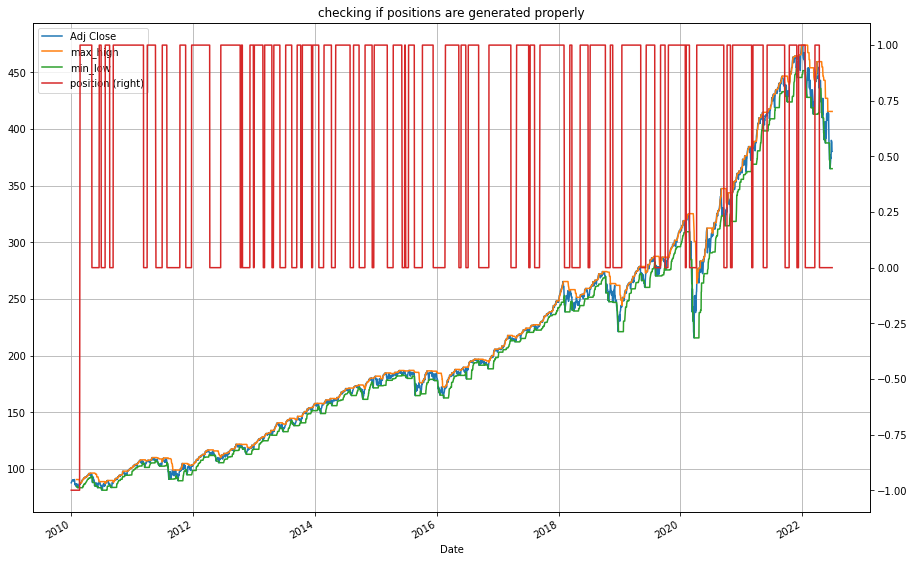

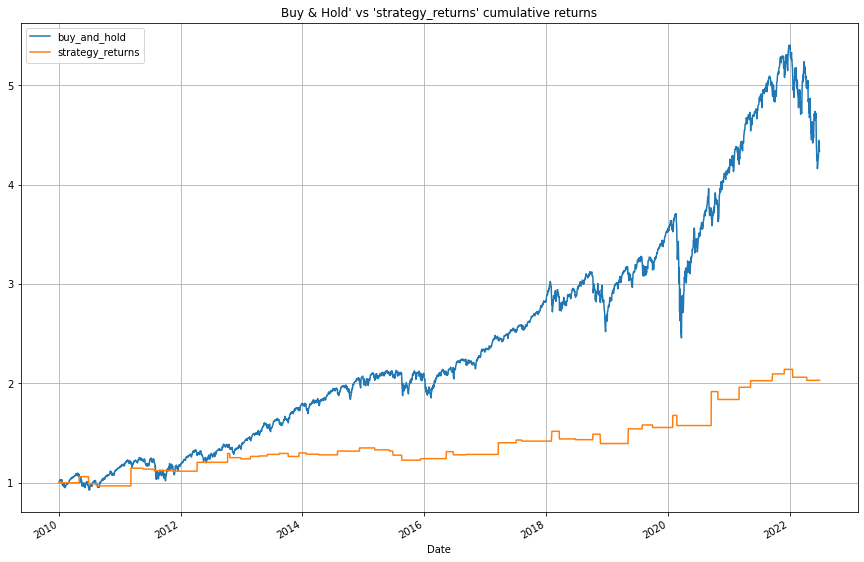

Start date,2009-12-31
End date,2022-06-29
Total months,149
,Backtest
Annual return,5.84%
Cumulative returns,103.07%
Annual volatility,11.571%
Sharpe ratio,0.54
Calmar ratio,0.64
Stability,0.86
Max drawdown,-9.106%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.11,2015-03-10,2015-08-20,2017-03-21,531
1,8.77,2010-06-28,2010-08-19,2011-03-10,184
2,8.11,2018-03-21,2018-11-23,2019-05-09,297
3,6.07,2020-02-24,2020-02-25,2020-09-18,150
4,5.15,2022-01-18,2022-04-14,NaT,NaN


Stress Events,mean,min,max
US downgrade/European Debt Crisis,0.00%,0.00%,0.00%
Fukushima,0.00%,0.00%,0.00%
EZB IR Event,0.32%,0.00%,7.38%
Flash Crash,0.00%,0.00%,0.00%
Apr14,-0.02%,-0.51%,0.00%
Oct14,0.00%,0.00%,0.00%
Fall2015,-0.12%,-3.92%,0.00%
Recovery,0.03%,-6.63%,18.39%
New Normal,0.02%,-6.32%,21.68%


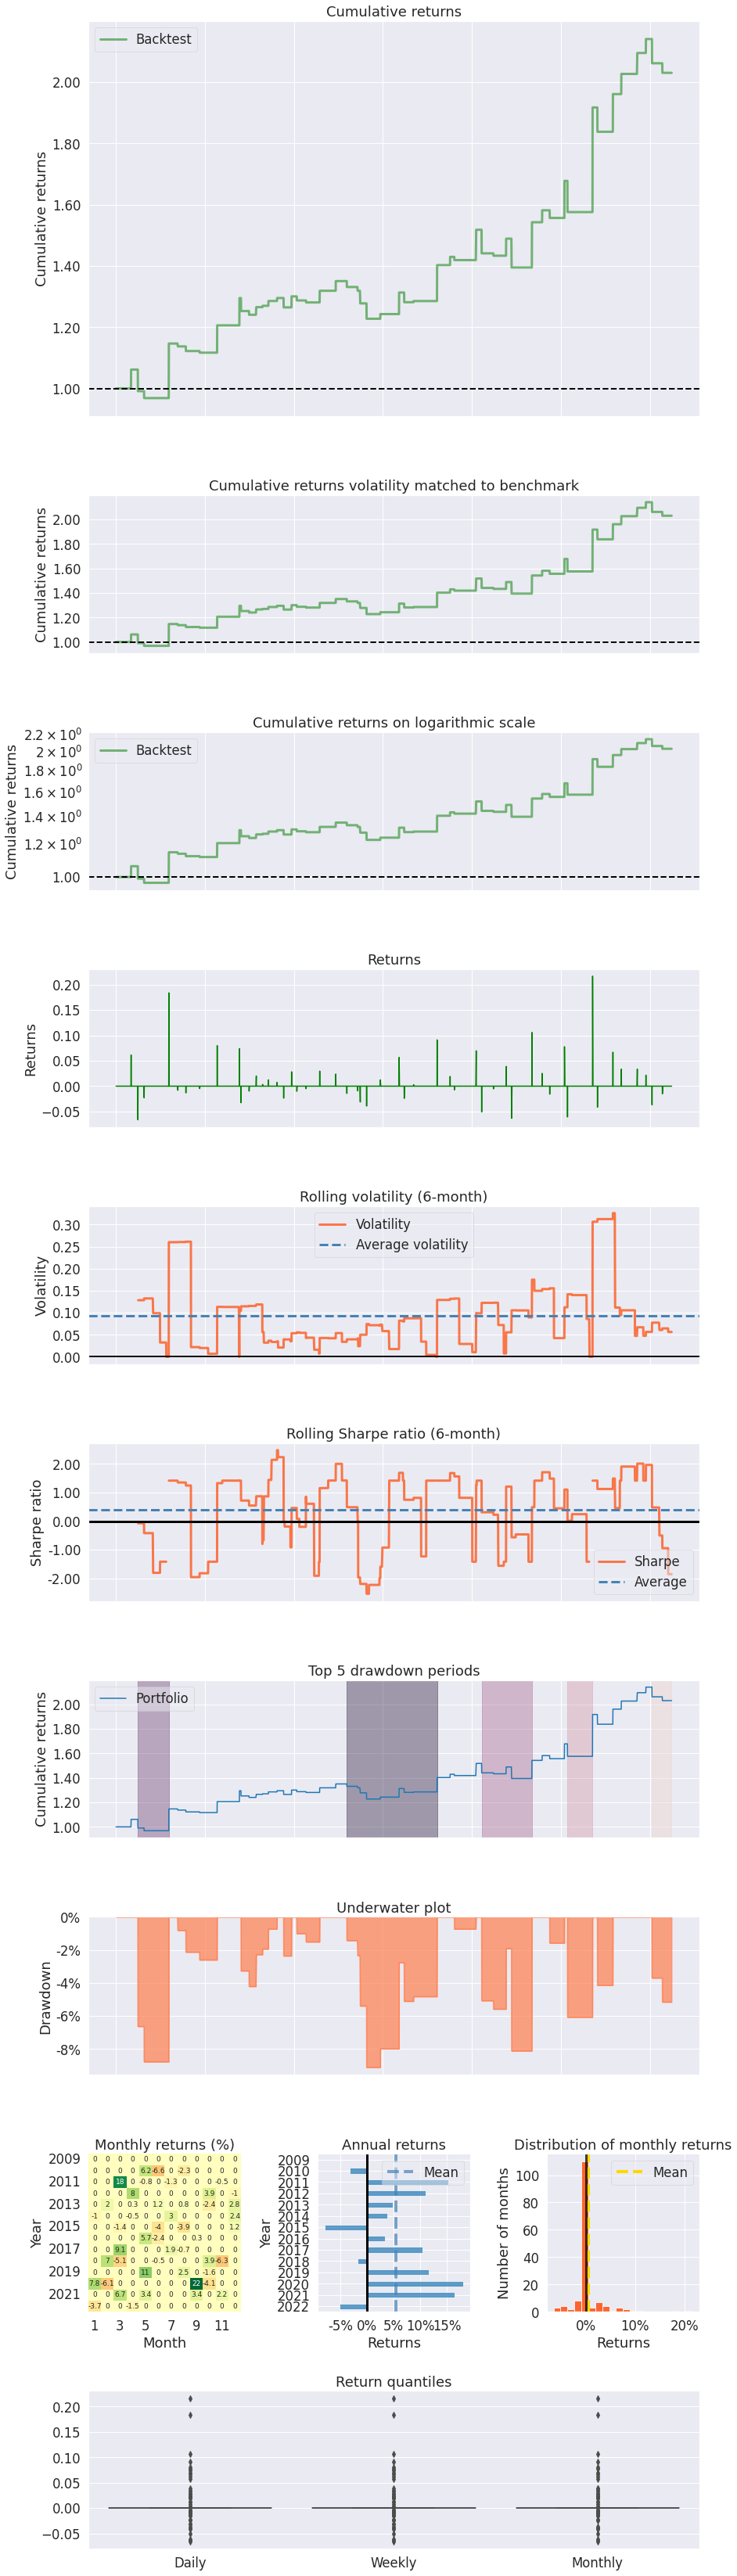

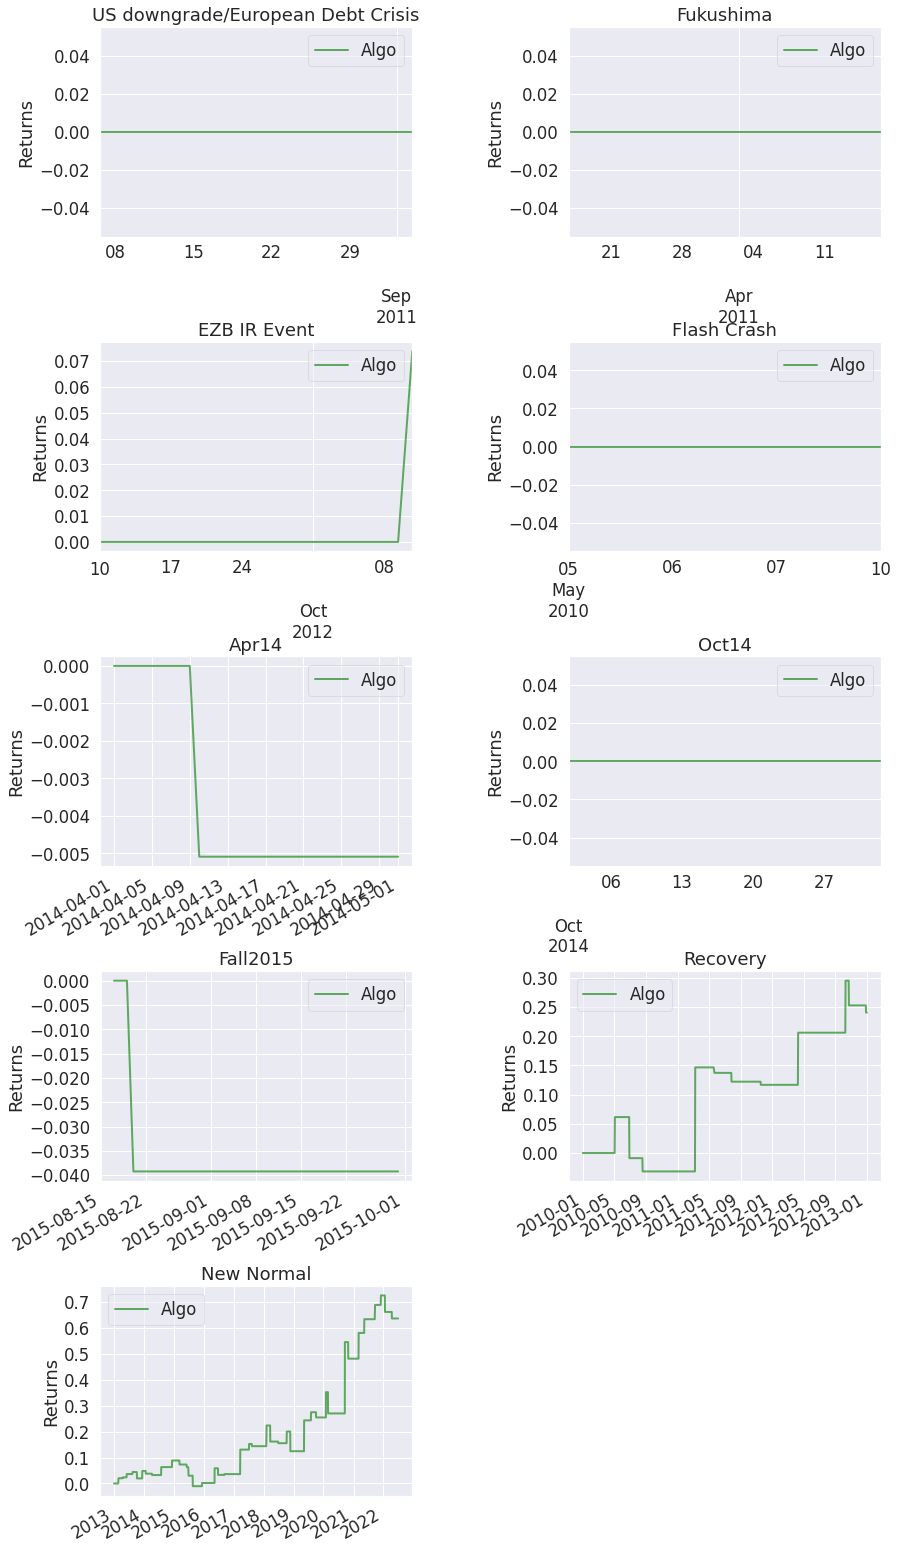

In [21]:
# Compute different metrics the strategy using pyfolio
turtle_strategy.analysis()

In [22]:
# parameter optimization
turtle_strategy.optimize_strategy()

Combinations to optimize: 16
num of cpus being used: 15
    lookback_high  lookback_low  strategy_returns
7              22            24        143.373156
3              21            24        142.330163
5              22            22        139.815165
9              23            22        137.363592
11             23            24        133.009548
1              21            22        131.332338
13             24            22        130.119717
15             24            24        125.898551
6              22            23        119.813720
2              21            23        118.871692

       lookback_high  lookback_low  strategy_returns
count      16.000000     16.000000         16.000000
mean       22.500000     22.500000        120.982417
std         1.154701      1.154701         17.389834
min        21.000000     21.000000         92.527707
25%        21.750000     21.750000        108.355011
50%        22.500000     22.500000        122.856135
75%        23.250000  